In [1]:
import torch
import torch.nn as nn
from torch.functional import F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL


%config InlineBackend.figure_format = 'svg'

In [2]:
use_cuda = True
device = torch.device('cuda:0' if use_cuda else 'cpu')
x = torch.Tensor([0]).cuda(device)

# 1. Load classify-leaves

In [3]:
class classifyLeaves(torch.utils.data.Dataset):
    def __init__(self, path = 'data/classify-leaves'):
        super(classifyLeaves, self).__init__()
        self.train_csv = pd.read_csv(path + '/train.csv').to_numpy()
        self.test_csv = pd.read_csv(path + '/test.csv').to_numpy()
        self.cls = np.array(sorted(list(set(self.train_csv[:,1]))))
        self.cls_num = len(self.cls)
        self.cls2idx = {self.cls[i]:i for i in range(self.cls_num)}
        self.idx2cls = {i:self.cls[i] for i in range(self.cls_num)}
        self.path = path
        import os
        if 'data.pt' in os.listdir(path):
            self.train_data, self.train_label, self.test_data, self.test_name = torch.load(path + '/data.pt')
        else:
            self.loadData()
            
    def loadData(self):
        self.train_data = []
        self.train_label = []
        self.test_data = []
        self.test_name = []
        
        i = 0
        l = len(self.train_csv)
        for name,clss in self.train_csv:
            i += 1
            print('\rLoading train data: [{i}/{l}]  '.format(i=i,l=l),end='')
            self.train_data.append(torchvision.io.read_image(path + '/' + name)/255)
            self.train_label.append(clss)
        print(' Success!')

        i = 0
        l = len(self.test_csv)
        for name, in self.test_csv:
            i += 1
            print('\rLoading test data: [{i}/{l}]  '.format(i=i,l=l),end='')
            self.test_data.append(torchvision.io.read_image(path + '/' + name)/255)
            self.test_name.append(name)
        print(' Success!')
        
        torch.save([self.train_data, self.train_label, self.test_data, self.test_name], self.path + '/data.pt')
        
    def __getitem__(self, index):
        return self.train_data[index], self.cls2idx[self.train_label[index]]
    
    def __len__(self):
        return len(self.train_csv)
    
    

In [4]:
path = 'data/classify-leaves'

In [5]:
dset = classifyLeaves()

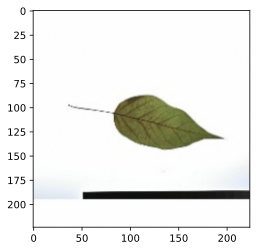

In [6]:
plt.imshow(dset.train_data[8].permute(1,2,0).numpy())

In [7]:
dataloader = torch.utils.data.DataLoader(dset, batch_size = 64, shuffle = True)

In [8]:
class BasicBlock(nn.Module):
    def __init__(self, input_channels, num_channels, stride = 1, downsample = None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 3, stride = stride, padding = 1)
        self.conv3 = nn.Conv2d(input_channels, num_channels, 1, stride = stride)
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        
        x = self.conv3(x)
        
        Y = F.relu(out + x)
        return Y

In [9]:
def Resnet_block(input_channels, num_channels, num_layers):
    blk = []
    for i in range(num_layers):
        blk.append(BasicBlock(input_channels, num_channels, stride = 2))
        input_channels = num_channels
    return blk

In [10]:
class Resnet_leaves(nn.Module):
    def __init__(self, input_channels, num_channels):
        super(Resnet_leaves, self).__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
        )
        self.b2 = nn.Sequential(*Resnet_block(64,64,2))
        self.b3 = nn.Sequential(*Resnet_block(64,128,2))
        self.b4 = nn.Sequential(*Resnet_block(128,256,2))
        self.b5 = nn.Sequential(*Resnet_block(256,512,2))
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(512, num_channels)
        self.softmax = nn.Softmax(dim = 1)
        
        
    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.softmax(x)
        return x

In [11]:
model = Resnet_leaves(3,176)
model.to(device)
x,y = iter(dataloader).next()
model(x.cuda(device)).shape

torch.Size([64, 176])

In [12]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
loss_func = nn.CrossEntropyLoss()

In [13]:
model.train()
for epoch in range(0):
    for step,(x,y) in enumerate(dataloader):
        x = x.cuda(device)
        y = y.cuda(device)
        y_ = model(x)
        
        loss = loss_func(y_,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = torch.sum(torch.argmax(y_, 1) == y)/y.shape[0]
        print('\r epoch:{epoch:5}--step:{step:7}--loss:{loss:.10}--acc:{acc:.5}'.format(epoch=epoch, step=step, loss=loss,acc = acc),end = '')

## It's too hard to train from beginning

# 2. What about pre-trained model?

In [14]:
import timm

In [15]:
class leavesNet(nn.Module):
    def __init__(self, out_channels):
        super(leavesNet, self).__init__()
        self.resnet50d = timm.models.resnet50d(pretrained=True)
        in_features = self.resnet50d.fc.in_features
        self.resnet50d.fc = nn.Linear(in_features, out_channels)
        
    def forward(self, x):
        x = self.resnet50d(x)
        return x

In [16]:
model = leavesNet(176)
model.to(device)
model(x.cuda(device)).shape

torch.Size([64, 176])

In [17]:
optimizer = optim.AdamW(model.parameters(), lr = 0.001)
loss_func = nn.CrossEntropyLoss().to(device)

In [27]:
model.train()
for epoch in range(5):
    for step,(x,y) in enumerate(dataloader):
        x = x.cuda(device)
        y = y.cuda(device)
        y_ = model(x)
        
        loss = loss_func(y_,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = torch.sum(torch.argmax(y_, 1) == y)/y.shape[0]
        print('\r epoch:{epoch:5}--step:{step:7}--loss:{loss:.10}--acc:{acc:.5}'.format(epoch=epoch, step=step, loss=loss,acc = acc),end = '')

 epoch:    4--step:    286--loss:0.05306992307--acc:0.97959

In [28]:
# torch.save(model, 'model/leavesNet_model.pt')

In [39]:
test_dataloader = torch.utils.data.DataLoader(list(zip(dset.test_data,dset.test_name)),batch_size = 64)

In [59]:
model.eval()
result = []
for step,(x,y) in enumerate(test_dataloader):
        x = x.cuda(device)
        y_ = model(x)
        for file, label in zip(y,y_.argmax(1)):
            result.append([file, dset.idx2cls[int(label)]])
        print('\r step:{step:7}'.format(step=step,),end = '')

 step:    137

In [61]:
result = np.array(result)
result

array([['images/18353.jpg', 'asimina_triloba'],
       ['images/18354.jpg', 'platanus_occidentalis'],
       ['images/18355.jpg', 'platanus_acerifolia'],
       ...,
       ['images/27150.jpg', 'pinus_thunbergii'],
       ['images/27151.jpg', 'juniperus_virginiana'],
       ['images/27152.jpg', 'juniperus_virginiana']], dtype='<U28')

In [63]:
result_pd = pd.DataFrame(result, columns= ['image', 'label'])

'data/classify-leaves/result.csv'

In [69]:
result_pd.to_csv(path + '/submission.csv', index=False)